# Merged model evaluation

In [64]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob



In [65]:
files = sorted(
    glob.glob(f'{ut.model_dir}//Models/Evaluation/nettekoven_68/eval_*'))

list_of_dfs = []
for f, file in enumerate(files):
    t = pd.read_csv(file, delimiter='\t')
    list_of_dfs.append(t)
    t['source'] = file.split('/')[-1].strip('.tsv')

D = pd.concat(list_of_dfs, ignore_index=True).reset_index(drop=True)
D.drop_duplicates(subset=D.columns.difference(['source']))

D.shape

(10128, 15)

In [66]:
crits = ['dcbc_group','dcbc_indiv']

figsize = (10,10)
# Determine origin of model: clustered_in_C3 (and then refitted to C2), clustered (on C2 or C3 data, but not refitted to another space), data (pure data-driven model)
for r,row in D.iterrows():
    if row['atlas'] == 'MNISymC2':
        if 'fromC3' in row['source']:
            D.loc[r,'origin'] = 'clustered_in_C3'
        elif 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'
    elif row['atlas'] == 'MNISymC3':
        if 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'

# Determine whether model was trained on rest, task and rest, or task only
for r,row in D.iterrows():
    if ['HCP'] == eval(row['train_data']):
        D.loc[r, 'trained_on'] = 'rest'
    elif 'HCP' in row['train_data']:
        D.loc[r, 'trained_on'] = 'task_and_rest'
    else:
        D.loc[r, 'trained_on'] = 'task'
        

# Determine whether model was tested on rest, task and rest, or task only
for r, row in D.iterrows():
    if 'HCP' == row['test_data']:
        D.loc[r, 'tested_on'] = 'rest'
    else:
        D.loc[r, 'tested_on'] = 'task'

# Leave-one-out indicator
loo = [ True if len(train.split(" ")) == 6 else False for t,train in enumerate(D.train_data) ]
individual = [ True if len(train.split(" ")) == 1 else False for t,train in enumerate(D.train_data) ]
all = [ True if len(train.split(" ")) == 7 else False for t,train in enumerate(D.train_data) ]

D['train_type_detailed'] = D['train_data']
D['train_type_detailed'][loo] = 'loo'
D['train_type_detailed'][all] = 'all'
D['train_type'] = D['train_type_detailed']
D['train_type'][individual] = 'individual'
# D['symmetric'] = True

# D.tail()


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_43429/3604612483.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D['train_type_detailed'][loo] = 'loo'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_43429/3604612483.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D['train_type_detailed'][all] = 'all'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_43429/3604612483.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

### Comparing clustered, clustered in C3 and data-driven parcellations for K=32

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_43429/1442773293.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).mean()


K  train_loglik  subj_num  common_kappa  \
atlas    origin                                                        
MNISymC2 clustered        32.0    64498792.0  29.14218           1.0   
         clustered_in_C3  32.0    65217792.0  29.14218           1.0   
         data             32.0    65320128.0  29.14218           1.0   
MNISymC3 clustered        32.0    19402024.0  29.14218           1.0   
         data             32.0    19622788.0  29.14218           1.0   

                          dcbc_group  dcbc_indiv  indivtrain_val  
atlas    origin                                                   
MNISymC2 clustered          0.088675    0.156923             1.5  
         clustered_in_C3    0.085500    0.156001             1.5  
         data               0.081123    0.158467             1.5  
MNISymC3 clustered          0.085098    0.156783             1.5  
         data               0.081469    0.158595             1.5

<Figure size 1000x1000 with 0 Axes>

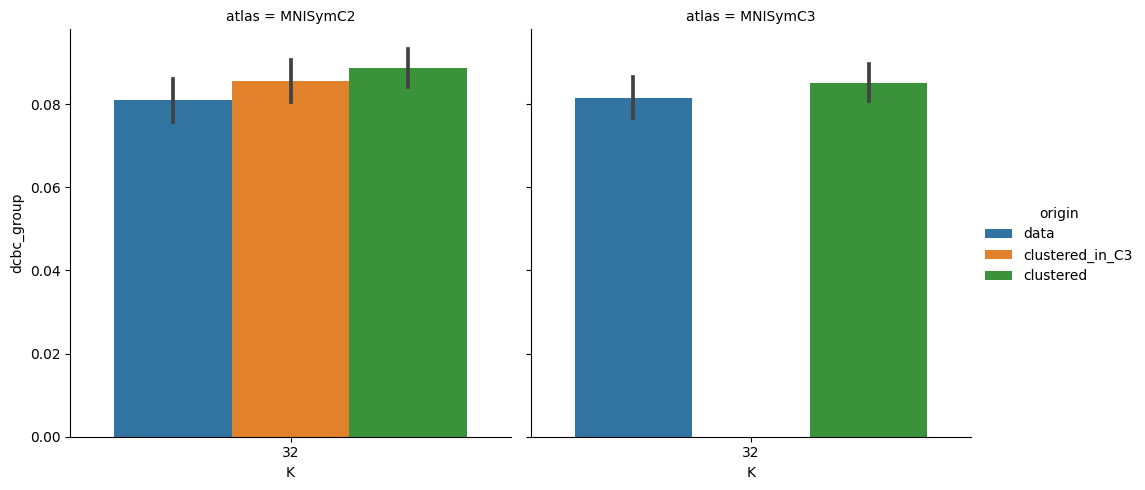

<Figure size 1000x1000 with 0 Axes>

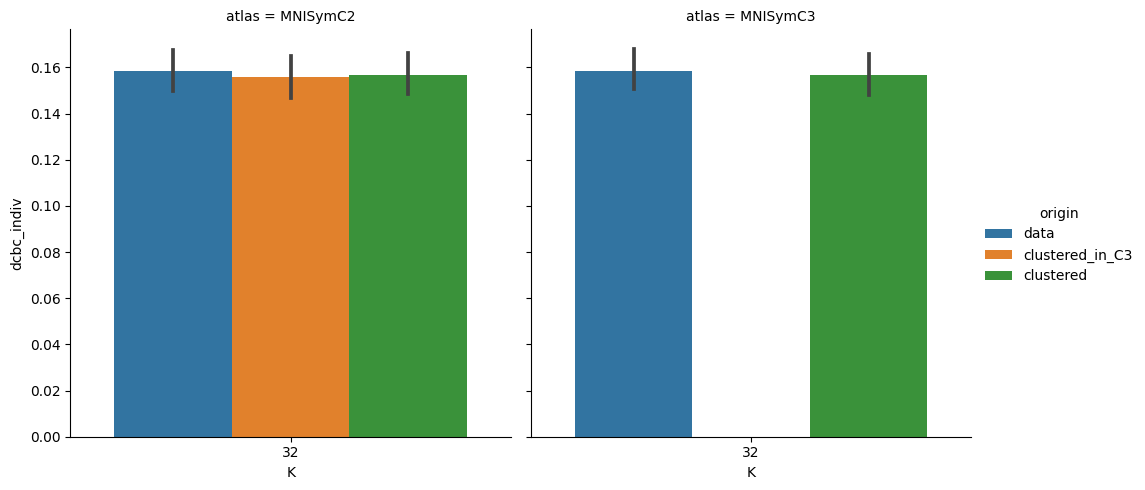

In [74]:

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.train_type == 'all') & (D.K == 32)], x="K", y="dcbc_group", col="atlas", hue="origin", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.train_type == 'all') & (D.K == 32)], x="K", y="dcbc_indiv", col="atlas", hue="origin", kind="bar")

# Get mean of DCBC for each origin
D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).mean()
# D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).std()

### Comparing pure task-trained, rest-and-task-trained, and rest-trained parcellations

<Figure size 1000x1000 with 0 Axes>

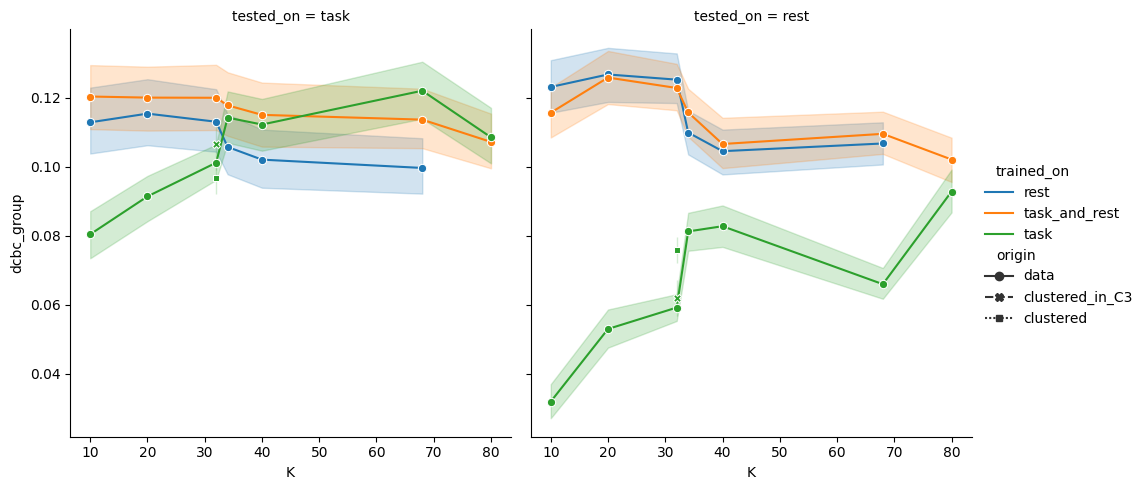

<Figure size 1000x1000 with 0 Axes>

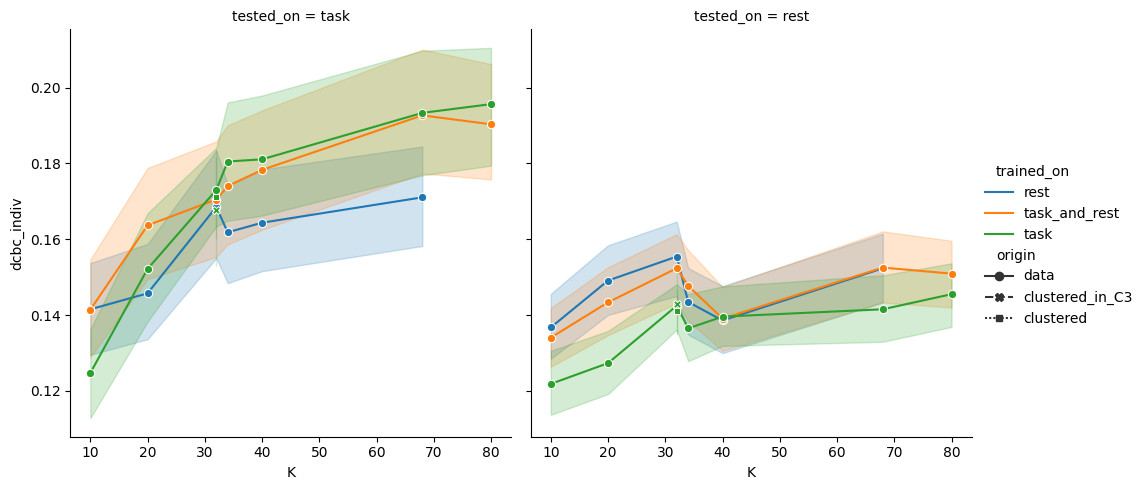

In [68]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D, x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D, x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)



<Figure size 1000x1000 with 0 Axes>

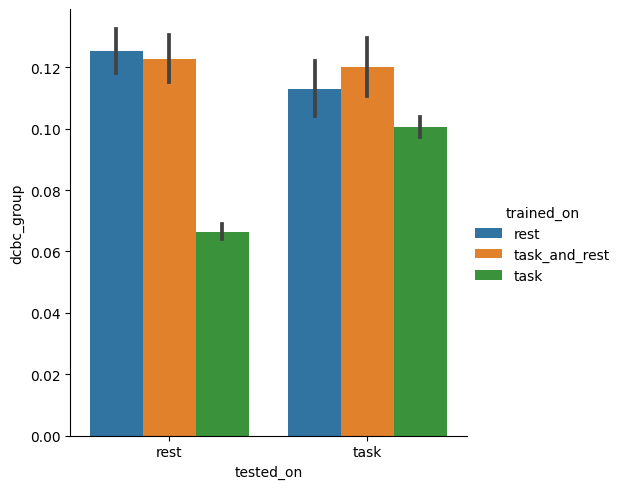

<Figure size 1000x1000 with 0 Axes>

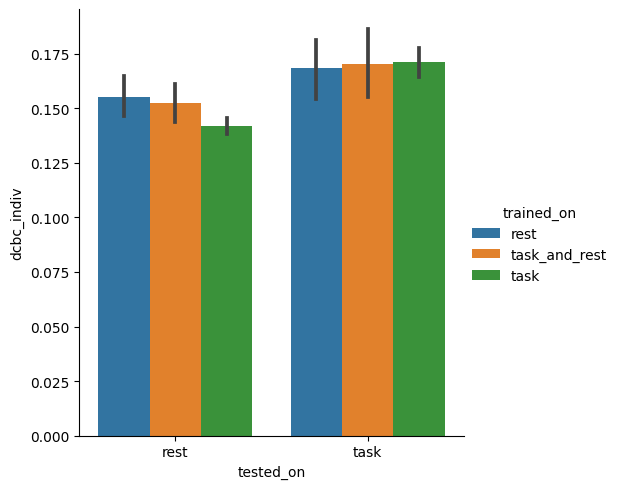

<Figure size 1000x1000 with 0 Axes>

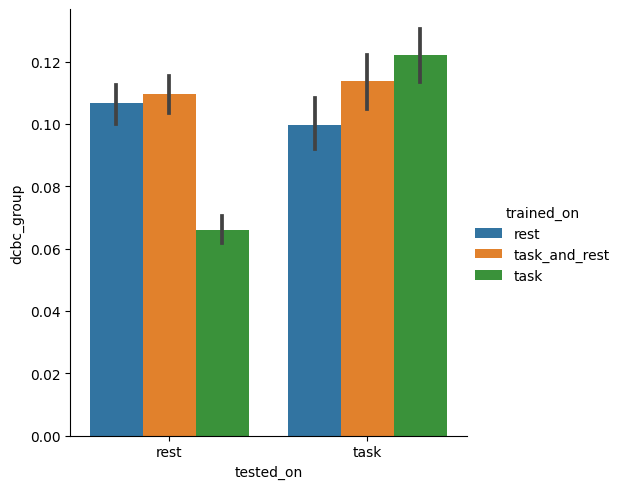

<Figure size 1000x1000 with 0 Axes>

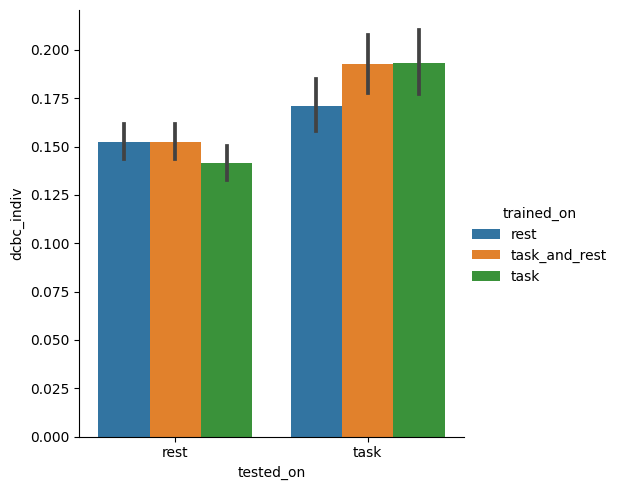

In [69]:

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 32)], x="tested_on", y="dcbc_group", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 32)], x="tested_on", y="dcbc_indiv", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 68)], x="tested_on", y="dcbc_group", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 68)], x="tested_on", y="dcbc_indiv", hue="trained_on", kind="bar")


### Comparing merged K 32 and data-derived K 34